# Load data

In [52]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ReadCSV').getOrCreate()

In [53]:
numPartition = 5
# train_data = sc.textFile('./data/train.csv',numPartition).map(lambda line: line.split(","))
# test_data = sc.textFile('./data/test.csv',numPartition).map(lambda line: line.split(","))
# header = train_data.first()
# train_data = train_data.filter(lambda line: line != header)
# test_data = test_data.filter(lambda line: line != header)
train_df = spark.read.csv('./data/train.csv',header=True,inferSchema=True).repartition(numPartition)
test_df = spark.read.csv('./data/test.csv',header=True,inferSchema=True).repartition(numPartition)
print(train_df)

DataFrame[id: int, clonesize: double, honeybee: double, bumbles: double, andrena: double, osmia: double, MaxOfUpperTRange: double, MinOfUpperTRange: double, AverageOfUpperTRange: double, MaxOfLowerTRange: double, MinOfLowerTRange: double, AverageOfLowerTRange: double, RainingDays: double, AverageRainingDays: double, fruitset: double, fruitmass: double, seeds: double, yield: double]


# Data Preprocess

In [54]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

def vector_to_double(vector):
    return float(vector[0])
udf_v2d = udf(vector_to_double, DoubleType())

input_cols = train_df.columns[1:-1]
output_col = train_df.columns[-1]

feat_assembler = VectorAssembler(inputCols=input_cols,outputCol="features")
yield_assembler = VectorAssembler(inputCols=[output_col],outputCol="yield_vec")

train_data = feat_assembler.transform(train_df).select("features",output_col)
train_data = yield_assembler.transform(train_data).select(['features','yield_vec'])

feature_scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",withStd=True, withMean=False)
yield_scaler = StandardScaler(inputCol="yield_vec", outputCol="scaledYield_vec",withStd=True, withMean=False)

train_data = feature_scaler.fit(train_data).transform(train_data)
train_data = yield_scaler.fit(train_data).transform(train_data)
train_data = train_data.withColumn('scaledYield',udf_v2d("scaledYield_vec")).select(['scaledFeatures','scaledYield'])

(train_data, val_data) = train_data.randomSplit([0.8,0.2])


# Simple Linear Regression

In [55]:
lr = LinearRegression(featuresCol = "scaledFeatures", labelCol = "scaledYield",maxIter=1000,regParam=0.01,elasticNetParam=0.8)

model = lr.fit(train_data)
train_result = model.transform(train_data)
train_result.select("prediction", "scaledYield", "scaledFeatures").show(5)
evaluator = RegressionEvaluator(
    labelCol="scaledYield", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(train_result)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

predictions = model.transform(val_data)
predictions.select("prediction", "scaledYield", "scaledFeatures").show(5)

evaluator = RegressionEvaluator(
    labelCol="scaledYield", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on val data = %g" % rmse)

print(model)  # summary only


+------------------+------------------+--------------------+
|        prediction|       scaledYield|      scaledFeatures|
+------------------+------------------+--------------------+
| 3.155806212491722| 2.861637678745875|[1.51625174965797...|
| 4.843817535178465|4.7320411775818005|[1.89531468707246...|
|3.3552313246753993| 2.863128490449435|[1.89531468707246...|
|5.1549784268716685| 4.664877227138155|[1.89531468707246...|
| 3.808689652927443| 3.973935948058426|[1.89531468707246...|
+------------------+------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on train data = 0.439043
+------------------+------------------+--------------------+
|        prediction|       scaledYield|      scaledFeatures|
+------------------+------------------+--------------------+
| 4.799161318420502|5.2300118286441295|[1.89531468707246...|
|3.1253926566286694|2.2805764171257423|[1.89531468707246...|
| 4.457102218075951| 4.575329688439023|[1.89531468707246...|
|4.8

Text(0.5, 1.0, 'Linear Regression Train Result')

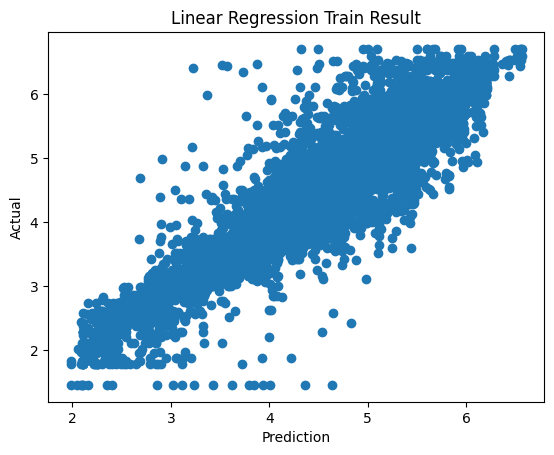

In [60]:
import matplotlib.pyplot as plt
import numpy as np


plt.scatter(np.array(train_result.select('prediction').collect()),np.array(train_result.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Linear Regression Train Result')

Text(0.5, 1.0, 'Linear Regression Validation Result')

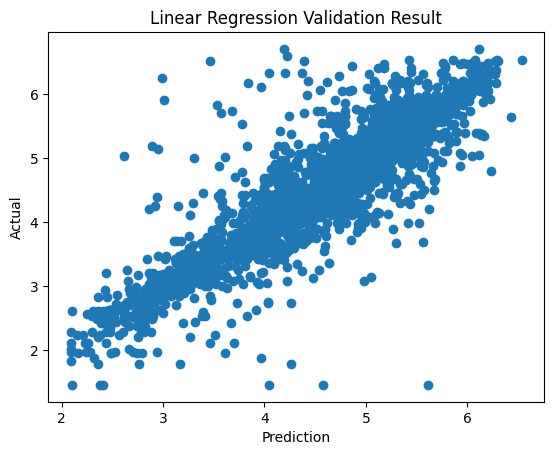

In [61]:
plt.scatter(np.array(predictions.select('prediction').collect()),np.array(predictions.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Linear Regression Validation Result')

# Random Forest Regressor

In [57]:
rf = RandomForestRegressor(featuresCol = "scaledFeatures", labelCol = "scaledYield",maxDepth=10,numTrees=20)
# print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")
model = rf.fit(train_data)
train_result = model.transform(train_data)
train_result.select("prediction", "scaledYield", "scaledFeatures").show(5)
evaluator = RegressionEvaluator(
    labelCol="scaledYield", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(train_result)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

predictions = model.transform(val_data)
predictions.select("prediction", "scaledYield", "scaledFeatures").show(5)

evaluator = RegressionEvaluator(
    labelCol="scaledYield", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on val data = %g" % rmse)

print(model)  # summary only

23/05/15 17:09:23 WARN DAGScheduler: Broadcasting large task binary with size 1513.9 KiB
23/05/15 17:09:24 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


+------------------+------------------+--------------------+
|        prediction|       scaledYield|      scaledFeatures|
+------------------+------------------+--------------------+
|2.7999857232315377| 2.861637678745875|[1.51625174965797...|
| 4.859900615818441|4.7320411775818005|[1.89531468707246...|
| 2.993941196151463| 2.863128490449435|[1.89531468707246...|
| 5.039430112224517| 4.664877227138155|[1.89531468707246...|
|3.9827710685635616| 3.973935948058426|[1.89531468707246...|
+------------------+------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on train data = 0.353944
+------------------+------------------+--------------------+
|        prediction|       scaledYield|      scaledFeatures|
+------------------+------------------+--------------------+
|4.9890432409499095|5.2300118286441295|[1.89531468707246...|
|2.6093516065614932|2.2805764171257423|[1.89531468707246...|
| 4.738379625746394| 4.575329688439023|[1.89531468707246...|
| 4.

Text(0, 0.5, 'Actual')

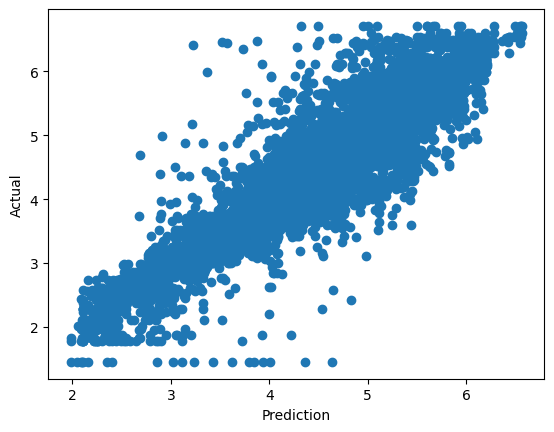

In [58]:
plt.scatter(np.array(train_result.select('prediction').collect()),np.array(train_result.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Random Forest Regression Train Result')

Text(0, 0.5, 'Actual')

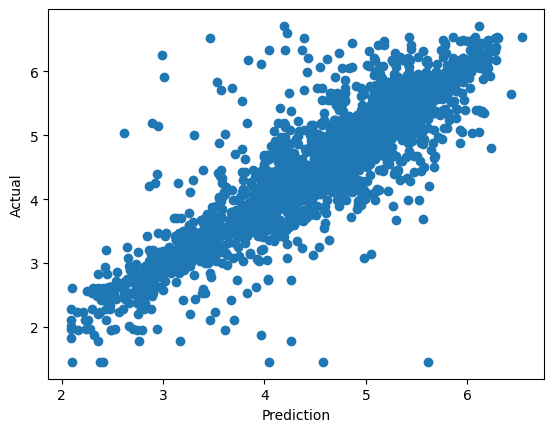

In [59]:
plt.scatter(np.array(predictions.select('prediction').collect()),np.array(predictions.select('scaledYield').collect()))
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Random Forest Regression Validation Result')

# Multi Layer Perceptron